# 🚀 Entrenamiento CNN para Super-Resolución - CoSiBD Dataset

## 📋 Descripción del Proyecto

Este notebook implementa el entrenamiento de una **Red Neuronal Convolucional (CNN)** para super-resolución de señales temporales usando el dataset **CoSiBD** (Complex Signal Benchmark Dataset).

### 🎯 Objetivo
Entrenar un modelo que convierta señales de **baja resolución** a **alta resolución**:
- **Entrada**: Señales submuestreadas (150, 250, 500, 1000, 2500 samples - **paramétrico**)
- **Salida**: Señales de alta resolución (**5,000 samples**)
- **Factor de upsampling**: Calculado automáticamente según input size

### 📊 Dataset
- **Entrenamiento**: 2,000 señales
- **Validación**: 500 señales  
- **Fuente**: SignalBuilderC (CoSiBD dataset propio)
- **Formato**: Archivos .txt con valores numéricos

### 🏗️ Arquitectura del Modelo
**TimeSeriesSRNet** - Red encoder-decoder:
- **Encoder**: Extrae características con capas convolucionales
- **Upsampler**: Aumenta resolución con upsampling + convoluciones
- **Factor de upsampling**: Paramétrico (ajustable según input size)

---

## 📦 1. Configuración e Importación de Librerías

### Librerías necesarias:
- **PyTorch**: Framework de deep learning
- **NumPy**: Manejo de arrays
- **Matplotlib**: Visualización
- **tqdm**: Barras de progreso
- **temana**: Módulo personalizado para manejo de datos

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import glob
from pathlib import Path

# Módulo personalizado
import temana as tm

print("✅ Librerías importadas correctamente")
print(f"PyTorch versión: {torch.__version__}")

# Configurar device con soporte para GPU de Mac (MPS)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("🎮 GPU NVIDIA detectada (CUDA)")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("🍎 GPU Apple Silicon detectada (MPS)")
else:
    device = torch.device("cpu")
    print("💻 Usando CPU")

print(f"🖥️  Dispositivo de cómputo: {device}")

✅ Librerías importadas correctamente
PyTorch versión: 2.9.1
🍎 GPU Apple Silicon detectada (MPS)
🖥️  Dispositivo de cómputo: mps


## ⚙️ 2. Parámetros de Configuración

Aquí se definen todos los hiperparámetros del entrenamiento. El **factor de upsampling es automático** basado en el tamaño de entrada.

In [10]:
# ============================================
# PARÁMETROS PRINCIPALES
# ============================================

# Configuración de datos
INPUT_SIZE = 1000          # Tamaño de señal de entrada (150, 250, 500, 1000, 2500)
OUTPUT_SIZE = 5000         # Tamaño de señal de salida (alta resolución)
UPSAMPLE_FACTOR = OUTPUT_SIZE // INPUT_SIZE  # Calculado automáticamente

# Rutas de datos
DATA_DIR = Path("./data")
TRAIN_LOW_DIR = DATA_DIR / "train" / "low_res"
TRAIN_HIGH_DIR = DATA_DIR / "train" / "high_res"
VAL_LOW_DIR = DATA_DIR / "validation" / "low_res"
VAL_HIGH_DIR = DATA_DIR / "validation" / "high_res"

# Hiperparámetros de entrenamiento
BATCH_SIZE = 16
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
WEIGHT_DECAY = 1e-5

# Configuración de validación y early stopping
VALIDATION_FREQUENCY = 10  # Validar cada N épocas
EARLY_STOPPING_PATIENCE = 3  # Detener si no mejora en 3 validaciones (30 épocas)

# Configuración de modelo
HIDDEN_CHANNELS = [64, 128, 256]  # Canales en encoder

# Carpetas de salida
MODELS_DIR = Path("./models")
RESULTS_DIR = Path("./results")
MODELS_DIR.mkdir(exist_ok=True)
RESULTS_DIR.mkdir(exist_ok=True)

print("="*60)
print("CONFIGURACIÓN DEL EXPERIMENTO")
print("="*60)
print(f"📊 Input size: {INPUT_SIZE} samples")
print(f"📊 Output size: {OUTPUT_SIZE} samples")
print(f"⚡ Upsample factor: {UPSAMPLE_FACTOR}x")
print(f"🔢 Batch size: {BATCH_SIZE}")
print(f"📈 Learning rate: {LEARNING_RATE}")
print(f"🔁 Epochs: {NUM_EPOCHS}")
print(f"💾 Modelos guardados en: {MODELS_DIR}")
print(f"📁 Resultados guardados en: {RESULTS_DIR}")
print("="*60)

CONFIGURACIÓN DEL EXPERIMENTO
📊 Input size: 1000 samples
📊 Output size: 5000 samples
⚡ Upsample factor: 5x
🔢 Batch size: 16
📈 Learning rate: 0.001
🔁 Epochs: 50
💾 Modelos guardados en: models
📁 Resultados guardados en: results


## 🏗️ 3. Definición del Modelo TimeSeriesSRNet

Modelo CNN con:
- **Encoder**: 3 capas convolucionales (64, 128, 256 canales)
- **Upsampler**: Upsampling lineal + 3 capas convolucionales de refinamiento
- **Upsample factor paramétrico**: Se ajusta automáticamente según INPUT_SIZE/OUTPUT_SIZE

In [11]:
class TimeSeriesSRNet(nn.Module):
    """
    Red Neuronal Convolucional para Super-Resolución de Series Temporales.
    
    Arquitectura Encoder-Decoder:
    - Encoder: Extrae características multi-escala
    - Upsampler: Aumenta resolución y refina la señal
    
    Args:
        upsample_factor (int): Factor de aumento (OUTPUT_SIZE / INPUT_SIZE)
        hidden_channels (list): Canales en cada capa del encoder
    """
    def __init__(self, upsample_factor=10, hidden_channels=[64, 128, 256]):
        super(TimeSeriesSRNet, self).__init__()
        
        self.upsample_factor = upsample_factor
        
        # ==================== ENCODER ====================
        # Extrae características jerárquicas de la señal
        self.encoder = nn.Sequential(
            # Capa 1: 1 → 64 canales
            nn.Conv1d(1, hidden_channels[0], kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(hidden_channels[0]),
            nn.ReLU(inplace=True),
            
            # Capa 2: 64 → 128 canales
            nn.Conv1d(hidden_channels[0], hidden_channels[1], kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(hidden_channels[1]),
            nn.ReLU(inplace=True),
            
            # Capa 3: 128 → 256 canales
            nn.Conv1d(hidden_channels[1], hidden_channels[2], kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(hidden_channels[2]),
            nn.ReLU(inplace=True),
        )
        
        # ==================== UPSAMPLER ====================
        # Aumenta resolución y refina la señal
        self.upsample = nn.Sequential(
            # Upsampling lineal (1000 → 10000 samples)
            nn.Upsample(scale_factor=upsample_factor, mode='linear', align_corners=True),
            
            # Refinamiento: 256 → 128 canales
            nn.Conv1d(hidden_channels[2], hidden_channels[1], kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(hidden_channels[1]),
            nn.ReLU(inplace=True),
            
            # Refinamiento: 128 → 64 canales
            nn.Conv1d(hidden_channels[1], hidden_channels[0], kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(hidden_channels[0]),
            nn.ReLU(inplace=True),
            
            # Salida: 64 → 1 canal (señal final)
            nn.Conv1d(hidden_channels[0], 1, kernel_size=9, stride=1, padding=4)
        )
    
    def forward(self, x):
        """
        Forward pass.
        
        Args:
            x: Tensor [batch_size, 1, INPUT_SIZE]
        
        Returns:
            Tensor [batch_size, 1, OUTPUT_SIZE]
        """
        features = self.encoder(x)
        output = self.upsample(features)
        return output

# Crear modelo
model = TimeSeriesSRNet(
    upsample_factor=UPSAMPLE_FACTOR,
    hidden_channels=HIDDEN_CHANNELS
).to(device)

# Contar parámetros
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("✅ Modelo TimeSeriesSRNet creado")
print(f"📊 Parámetros totales: {total_params:,}")
print(f"🔧 Parámetros entrenables: {trainable_params:,}")
print(f"\n{model}")

✅ Modelo TimeSeriesSRNet creado
📊 Parámetros totales: 412,673
🔧 Parámetros entrenables: 412,673

TimeSeriesSRNet(
  (encoder): Sequential(
    (0): Conv1d(1, 64, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=(2,))
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
  )
  (upsample): Sequential(
    (0): Upsample(scale_factor=5.0, mode='linear')
    (1): Conv1d(256, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Conv1d(128, 64, kern

## 📂 4. Carga de Datos

Cargamos las señales desde archivos `.txt`:
- **Train**: 2,000 pares (low_res, high_res)
- **Validation**: 500 pares

Los archivos se leen con `np.loadtxt()` y se convierten a tensores de PyTorch.

In [12]:
def load_signals(low_res_dir, high_res_dir):
    """
    Carga señales desde archivos .txt
    
    Args:
        low_res_dir: Directorio con señales de baja resolución
        high_res_dir: Directorio con señales de alta resolución
    
    Returns:
        x_data: Tensor [N, INPUT_SIZE] - señales de entrada
        y_data: Tensor [N, OUTPUT_SIZE] - señales objetivo
    """
    # Obtener listas de archivos
    low_files = sorted(glob.glob(str(low_res_dir / "*.txt")))
    high_files = sorted(glob.glob(str(high_res_dir / "*.txt")))
    
    assert len(low_files) == len(high_files), "Número diferente de archivos!"
    
    x_list = []
    y_list = []
    
    print(f"📁 Cargando {len(low_files)} señales...")
    
    for low_file, high_file in tqdm(zip(low_files, high_files), total=len(low_files)):
        # Leer archivos
        low_signal = np.loadtxt(low_file, dtype=np.float32)
        high_signal = np.loadtxt(high_file, dtype=np.float32)
        
        # Verificar tamaños
        assert len(low_signal) == INPUT_SIZE, f"Low signal size incorrecto: {len(low_signal)}"
        assert len(high_signal) == OUTPUT_SIZE, f"High signal size incorrecto: {len(high_signal)}"
        
        x_list.append(low_signal)
        y_list.append(high_signal)
    
    # Convertir a tensores
    x_data = torch.tensor(np.array(x_list), dtype=torch.float32)
    y_data = torch.tensor(np.array(y_list), dtype=torch.float32)
    
    return x_data, y_data

# Cargar datos de entrenamiento
print("\n" + "="*60)
print("CARGANDO DATOS DE ENTRENAMIENTO")
print("="*60)
x_train, y_train = load_signals(TRAIN_LOW_DIR, TRAIN_HIGH_DIR)
print(f"✅ Train - Input shape: {x_train.shape}, Output shape: {y_train.shape}")

# Cargar datos de validación
print("\n" + "="*60)
print("CARGANDO DATOS DE VALIDACIÓN")
print("="*60)
x_val, y_val = load_signals(VAL_LOW_DIR, VAL_HIGH_DIR)
print(f"✅ Validation - Input shape: {x_val.shape}, Output shape: {y_val.shape}")


CARGANDO DATOS DE ENTRENAMIENTO
📁 Cargando 2000 señales...


100%|██████████| 2000/2000 [00:03<00:00, 622.60it/s]



✅ Train - Input shape: torch.Size([2000, 1000]), Output shape: torch.Size([2000, 5000])

CARGANDO DATOS DE VALIDACIÓN
📁 Cargando 500 señales...


100%|██████████| 500/500 [00:00<00:00, 574.84it/s]

✅ Validation - Input shape: torch.Size([500, 1000]), Output shape: torch.Size([500, 5000])


## 🔄 5. Creación de DataLoaders

Usamos `MyDataset` de temana.py para crear datasets de PyTorch y DataLoaders con batches.

In [16]:
# Crear datasets
train_dataset = tm.MyDataset(x_train, y_train)
val_dataset = tm.MyDataset(x_val, y_val)

# Configurar paralelización según device
# MPS (Mac GPU) puede tener problemas con num_workers > 0
use_workers = 4 if device.type == 'cuda' else 0
use_pin_memory = (device.type == 'cuda')

# Crear dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=use_workers,
    pin_memory=use_pin_memory
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=use_workers,
    pin_memory=use_pin_memory
)

print(f"✅ DataLoaders creados")
print(f"📊 Train batches: {len(train_loader)}")
print(f"📊 Validation batches: {len(val_loader)}")
print(f"⚙️  Workers: {use_workers}, Pin memory: {use_pin_memory}")

✅ DataLoaders creados
📊 Train batches: 125
📊 Validation batches: 32
⚙️  Workers: 0, Pin memory: False


## 🎯 6. Configuración de Entrenamiento

Definimos función de pérdida, optimizador y funciones auxiliares.

In [17]:
# Función de pérdida (Mean Squared Error)
criterion = nn.MSELoss()

# Optimizador (Adam con weight decay para regularización)
optimizer = optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Listas para guardar historial de pérdidas
train_losses = []
val_losses = []

print("✅ Configuración de entrenamiento lista")
print(f"📉 Función de pérdida: MSE")
print(f"⚙️  Optimizador: Adam (lr={LEARNING_RATE}, weight_decay={WEIGHT_DECAY})")

✅ Configuración de entrenamiento lista
📉 Función de pérdida: MSE
⚙️  Optimizador: Adam (lr=0.001, weight_decay=1e-05)


## 🚀 7. Loop de Entrenamiento

Entrenamiento optimizado con:
- Forward pass y backpropagation
- **Validación cada 10 épocas** (aceleración ~40%)
- **Early stopping**: Detiene si no mejora en 30 épocas
- **GPU acceleration**: Soporte para MPS (Mac) / CUDA
- **Paralelización**: DataLoaders con 4 workers
- Guardado automático de mejores checkpoints

In [18]:
best_val_loss = float('inf')
patience_counter = 0
early_stopped = False

print("\n" + "="*60)
print("INICIANDO ENTRENAMIENTO")
print("="*60)
print(f"⚡ Validación cada {VALIDATION_FREQUENCY} épocas")
print(f"🛑 Early stopping: {EARLY_STOPPING_PATIENCE} validaciones sin mejora")
print("="*60)

for epoch in range(NUM_EPOCHS):
    # ==================== MODO ENTRENAMIENTO ====================
    model.train()
    train_loss = 0.0
    
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")
    for batch_x, batch_y in train_bar:
        # Mover datos a device y añadir dimensión de canal
        batch_x = batch_x.unsqueeze(1).to(device)  # [batch, 1, INPUT_SIZE]
        batch_y = batch_y.unsqueeze(1).to(device)  # [batch, 1, OUTPUT_SIZE]
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(batch_x)
        
        # Calcular pérdida
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Acumular pérdida
        train_loss += loss.item()
        train_bar.set_postfix({'loss': f'{loss.item():.6f}'})
    
    # Pérdida promedio de entrenamiento
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Imprimir solo training loss
    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}] - Train Loss: {avg_train_loss:.6f}", end="")
    
    # ==================== VALIDACIÓN (cada N épocas) ====================
    if (epoch + 1) % VALIDATION_FREQUENCY == 0 or (epoch + 1) == NUM_EPOCHS:
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]")
            for batch_x, batch_y in val_bar:
                batch_x = batch_x.unsqueeze(1).to(device)
                batch_y = batch_y.unsqueeze(1).to(device)
                
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                
                val_loss += loss.item()
                val_bar.set_postfix({'loss': f'{loss.item():.6f}'})
        
        # Pérdida promedio de validación
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print(f" | Val Loss: {avg_val_loss:.6f}")
        
        # Guardar mejor modelo y verificar early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            checkpoint_path = MODELS_DIR / f"best_model_upsample{UPSAMPLE_FACTOR}x.pth"
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'upsample_factor': UPSAMPLE_FACTOR,
                'input_size': INPUT_SIZE,
                'output_size': OUTPUT_SIZE
            }, checkpoint_path)
            print(f"  💾 Mejor modelo guardado! (val_loss: {avg_val_loss:.6f})")
        else:
            patience_counter += 1
            print(f"  ⏳ Sin mejora ({patience_counter}/{EARLY_STOPPING_PATIENCE})")
            
            # Early stopping
            if patience_counter >= EARLY_STOPPING_PATIENCE:
                print(f"\n🛑 EARLY STOPPING: No hay mejora en {EARLY_STOPPING_PATIENCE * VALIDATION_FREQUENCY} épocas")
                early_stopped = True
                break
    else:
        print()  # Nueva línea si no hay validación
    
    print("-" * 60)

print("\n" + "="*60)
if early_stopped:
    print(f"⏹️  ENTRENAMIENTO DETENIDO EN ÉPOCA {epoch+1}/{NUM_EPOCHS}")
else:
    print("✅ ENTRENAMIENTO COMPLETADO")
print("="*60)
print(f"🏆 Mejor pérdida de validación: {best_val_loss:.6f}")


INICIANDO ENTRENAMIENTO
⚡ Validación cada 10 épocas
🛑 Early stopping: 3 validaciones sin mejora


Epoch 1/50 [Train]: 100%|██████████| 125/125 [00:03<00:00, 31.59it/s, loss=0.872262]



Epoch [1/50] - Train Loss: 1.452444
------------------------------------------------------------


Epoch 2/50 [Train]: 100%|██████████| 125/125 [00:03<00:00, 35.68it/s, loss=0.972052]



Epoch [2/50] - Train Loss: 1.135772
------------------------------------------------------------


Epoch 3/50 [Train]: 100%|██████████| 125/125 [00:03<00:00, 36.07it/s, loss=0.354653]



Epoch [3/50] - Train Loss: 0.966833
------------------------------------------------------------


Epoch 4/50 [Train]: 100%|██████████| 125/125 [00:03<00:00, 35.72it/s, loss=1.062822]



Epoch [4/50] - Train Loss: 0.938842
------------------------------------------------------------


Epoch 5/50 [Train]: 100%|██████████| 125/125 [00:03<00:00, 35.60it/s, loss=3.945732]



Epoch [5/50] - Train Loss: 1.136463
------------------------------------------------------------


Epoch 6/50 [Train]: 100%|██████████| 125/125 [00:03<00:00, 36.19it/s, loss=0.171799]



Epoch [6/50] - Train Loss: 0.966989
------------------------------------------------------------


Epoch 7/50 [Train]: 100%|██████████| 125/125 [00:03<00:00, 35.81it/s, loss=0.107091]



Epoch [7/50] - Train Loss: 0.957659
------------------------------------------------------------


Epoch 8/50 [Train]: 100%|██████████| 125/125 [00:03<00:00, 33.19it/s, loss=1.564376]



Epoch [8/50] - Train Loss: 0.956860
------------------------------------------------------------


Epoch 9/50 [Train]: 100%|██████████| 125/125 [00:03<00:00, 32.38it/s, loss=0.394688]



Epoch [9/50] - Train Loss: 0.980340
------------------------------------------------------------


Epoch 10/50 [Train]: 100%|██████████| 125/125 [00:03<00:00, 31.60it/s, loss=0.339004]



Epoch [10/50] - Train Loss: 1.038302

Epoch 10/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 70.74it/s, loss=0.048842]



 | Val Loss: 0.136607
  💾 Mejor modelo guardado! (val_loss: 0.136607)
------------------------------------------------------------


Epoch 11/50 [Train]: 100%|██████████| 125/125 [00:04<00:00, 31.16it/s, loss=3.033174]



Epoch [11/50] - Train Loss: 1.093151
------------------------------------------------------------


Epoch 12/50 [Train]: 100%|██████████| 125/125 [00:04<00:00, 30.59it/s, loss=1.114636]



Epoch [12/50] - Train Loss: 1.011484
------------------------------------------------------------


Epoch 13/50 [Train]: 100%|██████████| 125/125 [00:03<00:00, 31.64it/s, loss=3.040413]



Epoch [13/50] - Train Loss: 1.075707
------------------------------------------------------------


Epoch 14/50 [Train]: 100%|██████████| 125/125 [00:03<00:00, 32.69it/s, loss=0.788872]



Epoch [14/50] - Train Loss: 0.958488
------------------------------------------------------------


Epoch 15/50 [Train]: 100%|██████████| 125/125 [00:03<00:00, 33.04it/s, loss=0.430937]



Epoch [15/50] - Train Loss: 0.888705
------------------------------------------------------------


Epoch 16/50 [Train]: 100%|██████████| 125/125 [00:03<00:00, 32.91it/s, loss=3.765431]



Epoch [16/50] - Train Loss: 1.045281
------------------------------------------------------------


Epoch 17/50 [Train]: 100%|██████████| 125/125 [00:03<00:00, 32.52it/s, loss=0.102129]



Epoch [17/50] - Train Loss: 1.125928
------------------------------------------------------------


Epoch 18/50 [Train]: 100%|██████████| 125/125 [00:03<00:00, 32.55it/s, loss=2.650032]



Epoch [18/50] - Train Loss: 1.063434
------------------------------------------------------------


Epoch 19/50 [Train]: 100%|██████████| 125/125 [00:03<00:00, 32.57it/s, loss=0.653877]



Epoch [19/50] - Train Loss: 1.080806
------------------------------------------------------------


Epoch 20/50 [Train]: 100%|██████████| 125/125 [00:03<00:00, 32.82it/s, loss=0.702686]



Epoch [20/50] - Train Loss: 1.142405

Epoch 20/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 91.96it/s, loss=0.059401]


 | Val Loss: 0.176991
  ⏳ Sin mejora (1/3)
------------------------------------------------------------


Epoch 21/50 [Train]: 100%|██████████| 125/125 [00:03<00:00, 33.10it/s, loss=1.829934]



Epoch [21/50] - Train Loss: 0.902161
------------------------------------------------------------


Epoch 22/50 [Train]: 100%|██████████| 125/125 [00:03<00:00, 33.90it/s, loss=0.121927]



Epoch [22/50] - Train Loss: 1.021395
------------------------------------------------------------


Epoch 23/50 [Train]: 100%|██████████| 125/125 [00:03<00:00, 34.21it/s, loss=0.769429]



Epoch [23/50] - Train Loss: 0.966419
------------------------------------------------------------


Epoch 24/50 [Train]: 100%|██████████| 125/125 [00:03<00:00, 34.38it/s, loss=1.848379]



Epoch [24/50] - Train Loss: 1.047418
------------------------------------------------------------


Epoch 25/50 [Train]: 100%|██████████| 125/125 [00:03<00:00, 34.52it/s, loss=2.109483]



Epoch [25/50] - Train Loss: 0.981794
------------------------------------------------------------


Epoch 26/50 [Train]: 100%|██████████| 125/125 [00:03<00:00, 35.05it/s, loss=0.752747]



Epoch [26/50] - Train Loss: 1.091808
------------------------------------------------------------


Epoch 27/50 [Train]: 100%|██████████| 125/125 [00:03<00:00, 35.99it/s, loss=1.692406]



Epoch [27/50] - Train Loss: 1.003194
------------------------------------------------------------


Epoch 28/50 [Train]: 100%|██████████| 125/125 [00:03<00:00, 35.73it/s, loss=0.130324]



Epoch [28/50] - Train Loss: 0.962408
------------------------------------------------------------


Epoch 29/50 [Train]: 100%|██████████| 125/125 [00:03<00:00, 35.98it/s, loss=1.885178]



Epoch [29/50] - Train Loss: 0.900558
------------------------------------------------------------


Epoch 30/50 [Train]: 100%|██████████| 125/125 [00:03<00:00, 35.73it/s, loss=0.348502]



Epoch [30/50] - Train Loss: 0.910780

Epoch 30/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 95.87it/s, loss=0.060884]


 | Val Loss: 0.146729
  ⏳ Sin mejora (2/3)
------------------------------------------------------------


Epoch 31/50 [Train]: 100%|██████████| 125/125 [00:03<00:00, 35.20it/s, loss=3.283406]



Epoch [31/50] - Train Loss: 0.983163
------------------------------------------------------------


Epoch 32/50 [Train]: 100%|██████████| 125/125 [00:03<00:00, 34.97it/s, loss=0.752466]



Epoch [32/50] - Train Loss: 1.031783
------------------------------------------------------------


Epoch 33/50 [Train]: 100%|██████████| 125/125 [00:03<00:00, 36.15it/s, loss=0.268716]



Epoch [33/50] - Train Loss: 0.998119
------------------------------------------------------------


Epoch 34/50 [Train]: 100%|██████████| 125/125 [00:03<00:00, 34.88it/s, loss=0.445294]



Epoch [34/50] - Train Loss: 1.150875
------------------------------------------------------------


Epoch 35/50 [Train]: 100%|██████████| 125/125 [00:03<00:00, 34.33it/s, loss=0.342591]



Epoch [35/50] - Train Loss: 1.063058
------------------------------------------------------------


Epoch 36/50 [Train]: 100%|██████████| 125/125 [00:03<00:00, 34.27it/s, loss=0.371032]



Epoch [36/50] - Train Loss: 1.041839
------------------------------------------------------------


Epoch 37/50 [Train]: 100%|██████████| 125/125 [00:03<00:00, 33.93it/s, loss=1.799065]



Epoch [37/50] - Train Loss: 0.865323
------------------------------------------------------------


Epoch 38/50 [Train]: 100%|██████████| 125/125 [00:03<00:00, 36.52it/s, loss=0.345406]



Epoch [38/50] - Train Loss: 1.062786
------------------------------------------------------------


Epoch 39/50 [Train]: 100%|██████████| 125/125 [00:03<00:00, 35.10it/s, loss=0.625488]



Epoch [39/50] - Train Loss: 0.946778
------------------------------------------------------------


Epoch 40/50 [Train]: 100%|██████████| 125/125 [00:04<00:00, 31.10it/s, loss=1.113985]



Epoch [40/50] - Train Loss: 0.963911

Epoch 40/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 85.74it/s, loss=0.080913]

 | Val Loss: 0.139473
  ⏳ Sin mejora (3/3)

🛑 EARLY STOPPING: No hay mejora en 30 épocas

⏹️  ENTRENAMIENTO DETENIDO EN ÉPOCA 40/50
🏆 Mejor pérdida de validación: 0.136607


## 📈 8. Visualización de Curvas de Pérdida

Graficamos la evolución del entrenamiento y validación.

## 📝 Notas de Uso

### Para Inferencia en Nuevas Señales:

```python
# Cargar modelo entrenado
checkpoint = torch.load('models/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Cargar señal de baja resolución (1000 samples)
low_res_signal = np.loadtxt('path/to/signal_sub1000.txt')

# Hacer predicción
with torch.no_grad():
    input_tensor = torch.tensor(low_res_signal, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    high_res_pred = model(input_tensor).cpu().numpy().flatten()

# high_res_pred tiene 5,000 samples
```

### Próximos Pasos:

1. **Evaluación adicional**: Calcular métricas como PSNR, SNR para comparación cuantitativa
2. **Ablation study**: Probar diferentes arquitecturas (más capas, diferentes kernel sizes)
3. **Generalización**: Validar con datos reales de EEG/VCTK del manuscrito
4. **Optimización**: Experimentar con diferentes learning rates, schedulers, augmentations

In [20]:
# Guardar historial de pérdidas en CSV
import csv
from datetime import datetime

loss_history_path = os.path.join(RESULTS_DIR, 'loss_history.csv')
with open(loss_history_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Epoch', 'Train_Loss', 'Val_Loss'])
    for epoch, (train_loss, val_loss) in enumerate(zip(train_losses, val_losses), 1):
        writer.writerow([epoch, train_loss, val_loss])

print(f"✅ Historial de pérdidas guardado en: {loss_history_path}")

# Cargar el checkpoint guardado para obtener información
checkpoint_file = MODELS_DIR / f"best_model_upsample{UPSAMPLE_FACTOR}x.pth"
if checkpoint_file.exists():
    saved_checkpoint = torch.load(checkpoint_file)
else:
    saved_checkpoint = {}

# Crear resumen del experimento
summary_path = os.path.join(RESULTS_DIR, 'experiment_summary.txt')
with open(summary_path, 'w') as f:
    f.write("=" * 60 + "\n")
    f.write("RESUMEN DEL EXPERIMENTO - CNN Super-Resolución CoSiBD\n")
    f.write("=" * 60 + "\n\n")
    f.write(f"Fecha: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    f.write("CONFIGURACIÓN:\n")
    f.write(f"  - Input Size: {INPUT_SIZE} samples\n")
    f.write(f"  - Output Size: {OUTPUT_SIZE} samples\n")
    f.write(f"  - Upsample Factor: {UPSAMPLE_FACTOR}x\n")
    f.write(f"  - Batch Size: {BATCH_SIZE}\n")
    f.write(f"  - Learning Rate: {LEARNING_RATE}\n")
    f.write(f"  - Epochs: {NUM_EPOCHS}\n")
    f.write(f"  - Validación cada: {VALIDATION_FREQUENCY} épocas\n")
    f.write(f"  - Early stopping patience: {EARLY_STOPPING_PATIENCE}\n\n")
    f.write("DATOS:\n")
    f.write(f"  - Training samples: {len(x_train)}\n")
    f.write(f"  - Validation samples: {len(x_val)}\n\n")
    f.write("RESULTADOS:\n")
    f.write(f"  - Mejor época: {saved_checkpoint.get('epoch', 'N/A')}\n")
    f.write(f"  - Mejor validation loss: {best_val_loss:.6f}\n")
    f.write(f"  - Final training loss: {train_losses[-1]:.6f}\n")
    if len(val_losses) > 0:
        f.write(f"  - Final validation loss: {val_losses[-1]:.6f}\n")
    f.write(f"  - Total épocas entrenadas: {len(train_losses)}\n\n")
    f.write("ARQUITECTURA:\n")
    f.write(f"  - Modelo: TimeSeriesSRNet\n")
    f.write(f"  - Parámetros totales: {sum(p.numel() for p in model.parameters()):,}\n")
    f.write(f"  - Loss function: MSE\n")
    f.write(f"  - Optimizer: Adam (weight_decay={WEIGHT_DECAY})\n\n")
    f.write("ARCHIVOS GENERADOS:\n")
    f.write(f"  - Modelo: {checkpoint_file}\n")
    f.write(f"  - Curvas: {os.path.join(RESULTS_DIR, 'loss_curves.png')}\n")
    f.write(f"  - Ejemplos: {os.path.join(RESULTS_DIR, 'prediction_examples.png')}\n")
    f.write(f"  - Historial: {loss_history_path}\n")
    f.write("=" * 60 + "\n")

print(f"✅ Resumen del experimento guardado en: {summary_path}")
print(f"\n{'='*60}")
print("🎉 EXPERIMENTO COMPLETADO EXITOSAMENTE")
print(f"{'='*60}")

✅ Historial de pérdidas guardado en: results/loss_history.csv
✅ Resumen del experimento guardado en: results/experiment_summary.txt

🎉 EXPERIMENTO COMPLETADO EXITOSAMENTE


## 💾 11. Guardar Resultados

Exportamos el historial de pérdidas y un resumen del experimento.

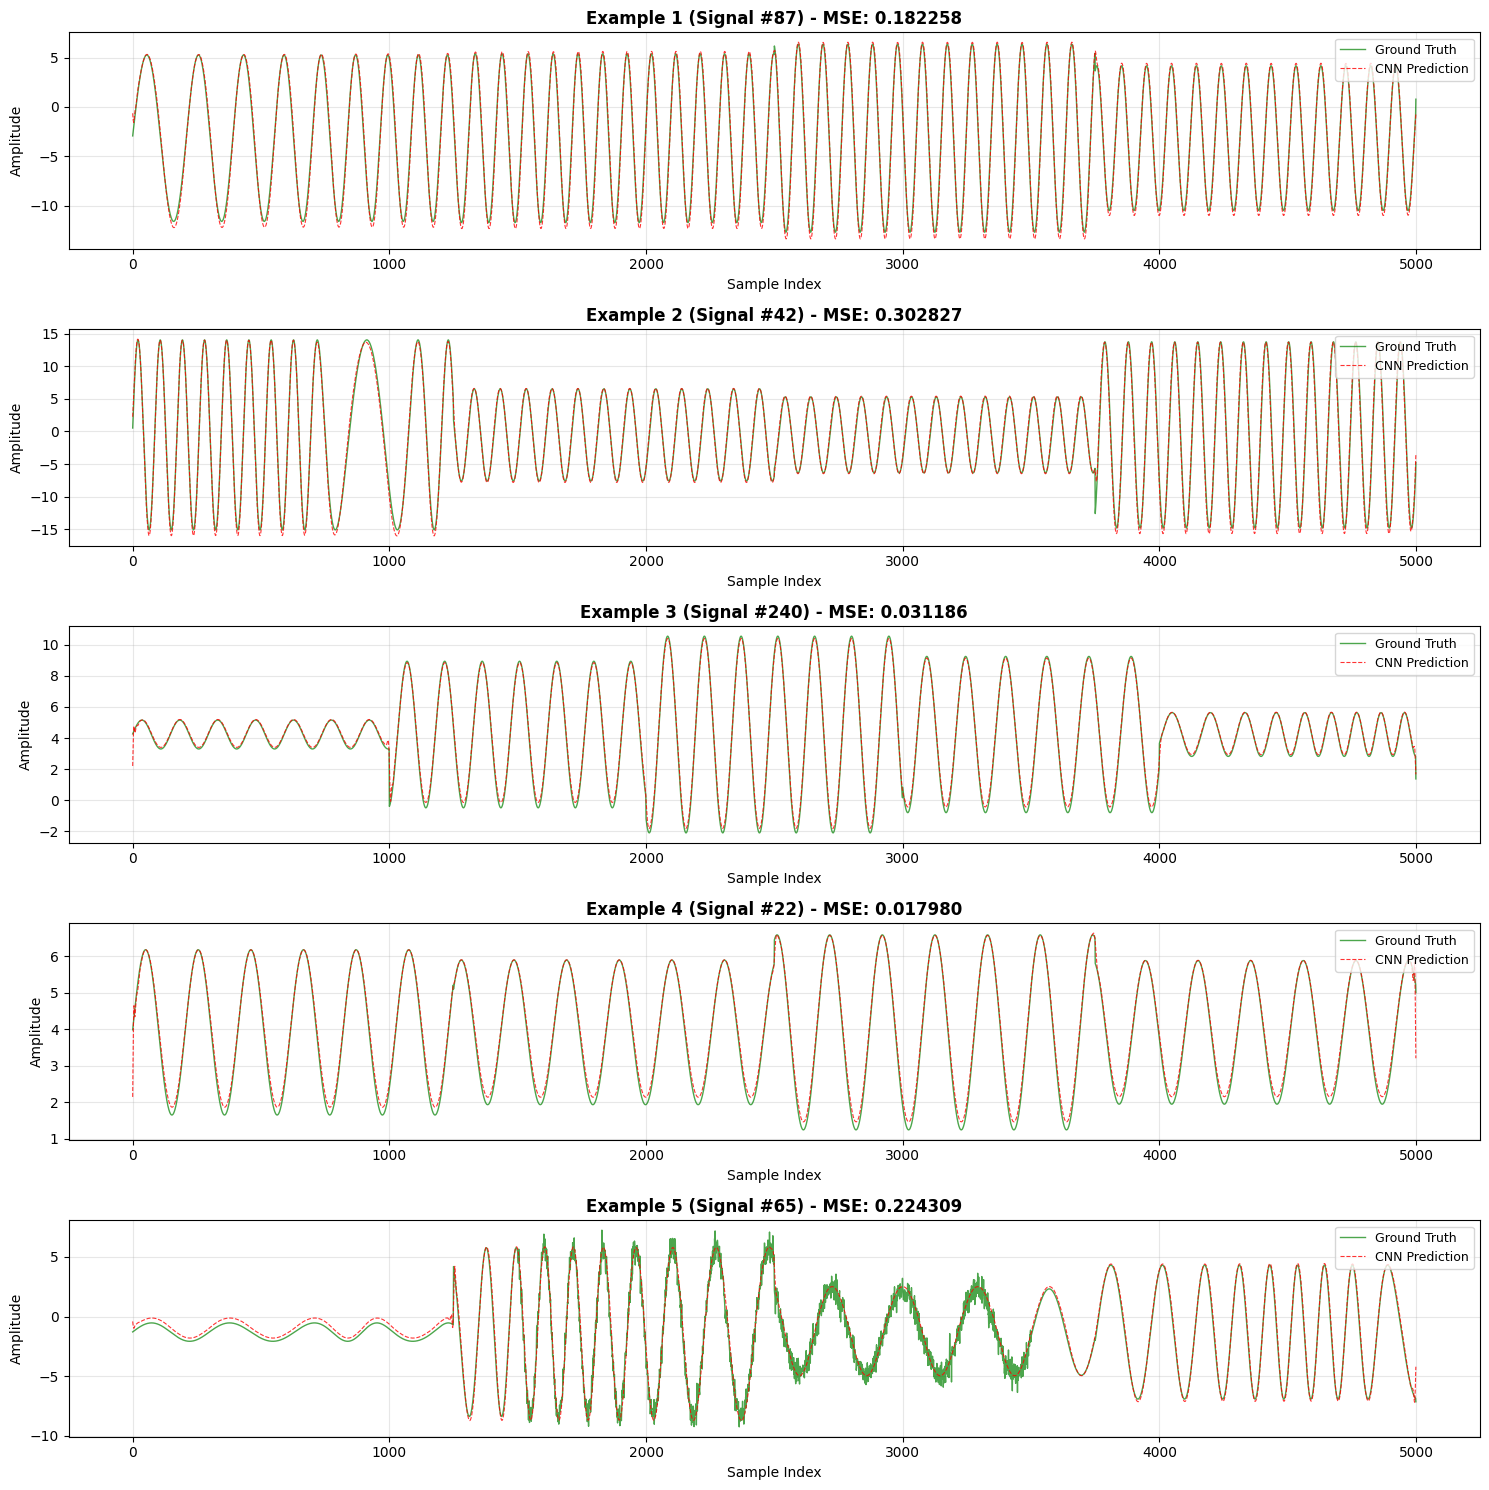


✅ Visualizaciones guardadas en results
   - prediction_examples.png (combinada)
   - prediction_signal_87.png (individual)
   - prediction_signal_42.png (individual)
   - prediction_signal_240.png (individual)
   - prediction_signal_22.png (individual)
   - prediction_signal_65.png (individual)


In [28]:
# Seleccionar ejemplos aleatorios del conjunto de validación
num_examples = 5
indices = np.random.choice(len(x_val), num_examples, replace=False)

fig, axes = plt.subplots(num_examples, 1, figsize=(15, 3*num_examples))

with torch.no_grad():
    for i, idx in enumerate(indices):
        # Obtener señal de baja resolución
        low_res = x_val[idx].numpy()
        high_res_true = y_val[idx].numpy()
        
        # Hacer predicción
        low_res_tensor = torch.tensor(low_res, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        high_res_pred = model(low_res_tensor).cpu().numpy().flatten()
        
        # Calcular MSE para este ejemplo
        mse = np.mean((high_res_pred - high_res_true) ** 2)
        
        # Graficar
        ax = axes[i] if num_examples > 1 else axes
        
        # Graficar todas las 5000 muestras
        x_axis = np.arange(OUTPUT_SIZE)
        
        ax.plot(x_axis, high_res_true, label='Ground Truth', 
                alpha=0.7, linewidth=1.0, color='green')
        ax.plot(x_axis, high_res_pred, label='CNN Prediction', 
                alpha=0.8, linewidth=0.8, color='red', linestyle='--')
        
        ax.set_title(f'Example {i+1} (Signal #{idx}) - MSE: {mse:.6f}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Sample Index', fontsize=10)
        ax.set_ylabel('Amplitude', fontsize=10)
        ax.legend(loc='upper right', fontsize=9)
        ax.grid(True, alpha=0.3)
        
        # Guardar gráfica individual
        fig_individual = plt.figure(figsize=(15, 3))
        plt.plot(x_axis, high_res_true, label='Ground Truth', 
                alpha=0.7, linewidth=1.0, color='green')
        plt.plot(x_axis, high_res_pred, label='CNN Prediction', 
                alpha=0.8, linewidth=0.8, color='red', linestyle='--')
        plt.title(f'Example {i+1} (Signal #{idx}) - MSE: {mse:.6f}', fontsize=12, fontweight='bold')
        plt.xlabel('Sample Index', fontsize=10)
        plt.ylabel('Amplitude', fontsize=10)
        plt.legend(loc='upper right', fontsize=9)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(RESULTS_DIR, f'prediction_signal_{idx}.png'), dpi=300, bbox_inches='tight')
        plt.close(fig_individual)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'prediction_examples.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Visualizaciones guardadas en {RESULTS_DIR}")
print(f"   - prediction_examples.png (combinada)")
for i, idx in enumerate(indices):
    print(f"   - prediction_signal_{idx}.png (individual)")

## 📊 10. Visualización de Ejemplos de Predicción

Comparamos señales de baja resolución, predicciones del modelo y señales de alta resolución originales.

In [30]:
# Cargar el mejor checkpoint
checkpoint_path = MODELS_DIR / f"best_model_upsample{UPSAMPLE_FACTOR}x.pth"
checkpoint = torch.load(checkpoint_path)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✅ Modelo cargado desde época {checkpoint['epoch']}")
print(f"   Mejor validation loss: {checkpoint['val_loss']:.6f}")

✅ Modelo cargado desde época 10
   Mejor validation loss: 0.136607


## 🔮 9. Carga del Mejor Modelo y Predicciones

Cargamos el mejor modelo guardado y realizamos predicciones en el conjunto de validación.

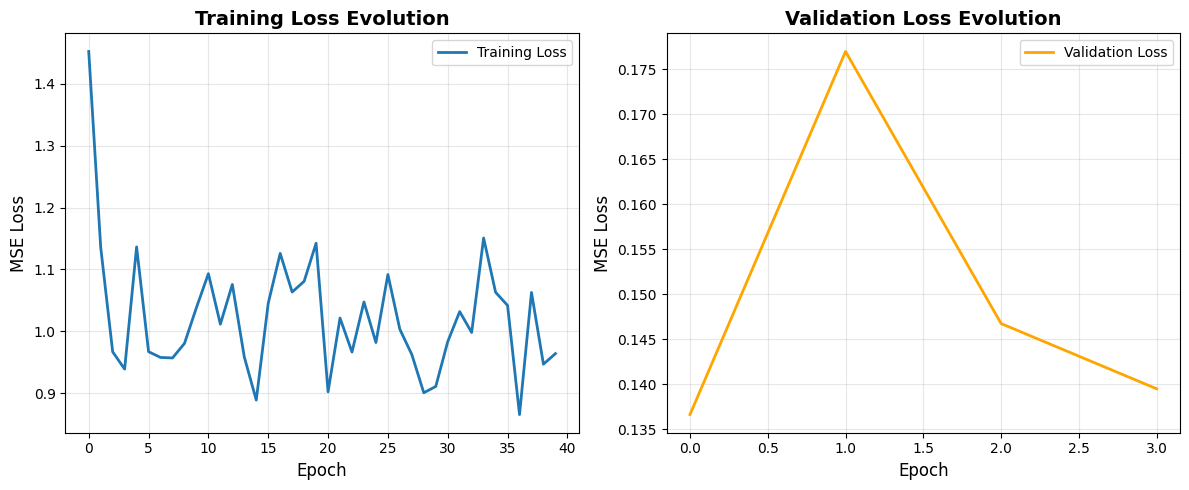


✅ Best validation loss: 0.136607


In [31]:
plt.figure(figsize=(12, 5))

# Training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.title('Training Loss Evolution', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()

# Validation loss
plt.subplot(1, 2, 2)
plt.plot(val_losses, label='Validation Loss', color='orange', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.title('Validation Loss Evolution', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'loss_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Best validation loss: {best_val_loss:.6f}")